# Predicting sexist political views from a household quality of life survey in Medellin, Colombia

Authors: Cara Nolan (cara_nolan@berkeley.edu), Mia Hart (mia_hart@berkeley.edu)

# Abstract

Achieving gender equality in politics is a core goal for the Colombian city of Medellin. The city has implemented quotas on female political representation, but such interventions will fail to achieve gender equality if the citizens do not trust female political leaders equally to men. This study aims to investigate whether sexist political beliefs can be predicted by using data from an annual household quality of life survey concerning a person's demographic information and level of political engagement. This could inform understanding of sexism in politics, and help target gender equality advocacy interventions. We find that a logistic regression model with responses to 32 survey questions has 62% accuracy in predicting sexist political beliefs as measured by responses to the question: "do you believe men are better political leaders than women?". A model with only political engagement features performs as strongly as a model with demographic features included, but none of the models have high accuracy. We conclude that, given the complex and nuanced nature of sexist beliefs, it is not possible to accurately predict sexism according to the questions in this survey and recommend further analysis using different datasets that have explicitly gathered information with the purpose of measuring views on gender equality, such as the national 'Como Vamos' survey.

# 1. Introduction

Gender equality is a core priority for Colombia at a national level, and for its second largest city, Medellin. In 2000, the country passed a ‘quota’ law (Law 581), which established that a minimum of 30 percent of appointed positions in Colombia’s upper public administration must be occupied by women (UNDP, 2012). In 2011, under Law 1475, Colombia required the participation of women in at least 30% of the electoral list of political parties (UNDP, 2012). In line with its objectives under the United Nations Sustainable Development Goals, the city of Medellin has announced a focus on women’s empowerment in its strategic plan for 2030 (Medellin Como Vamos, 2018). To achieve the stated aims on gender equality, quotas alone are not enough. Female politicians in office must also be perceived with the same level of trust and respect afforded to male politicians. 

In its annual household quality of life survey (Encuesta calidad de vida), the city of Medellin gathers data on the socio-economic conditions of the residents of Medellin, across dimensions including population, housing, education, health and social security, and civic participation and citizen perceptions of the city. One of the questions that it asks is “Do you believe that men are better political leaders than women?” This question is an important indicator of citizens’ ‘sexist’ beliefs, and serves as a barometer on whether the quotas for female political representation are having any effect in terms of progress towards gender equality.
Using this question as a proxy for sexist beliefs in relation to political involvement of women, it would be helpful to those advocating for gender equality to understand whether sexist beliefs can be predicted by any material factors (such as age, sex, socioeconomic status, occupation etc.) or any factors to do with political engagement (such as voting in the most recent election, overall trust and satisfaction in government, family involvement in politics etc.). If these factors are able to predict sexism, then we may be able to shed light on some of the reasons sexist beliefs are sustained. We may also be able to improve targeting of advocacy campaigns to those groups with disproportionately high rates of sexist views. 

As such, the research question for this study is: _**“Can sexist views in relation to the political capability of women be predicted based on demographic factors and level of political engagement, in Medelllin, Colombia?”**_

Our hypothesis is that there may be a small degree of predictive power in these features, but we are hesitant to suggest that a robust model will be able to be generated from these features, given the subjective and complex nature of the creation and perpetuation of sexist beliefs. 

References:
* UNDP, 2012. _Gender Equality and Women’s Empowerment in Public Administration: A Colombia Case Study._ Accessed at: 
https://www.undp.org/content/dam/undp/library/Democratic%20Governance/Women-s%20Empowerment/ColombiaFinal%20-%20HiRes.pdf

* Medellin Como Vamos, 2018. _¿Cómo está la calidad de vida de las mujeres en Medellín?_ Accessed at: https://www.medellincomovamos.org/mujeres-2018/

# 2. Data
The data used for this analysis is the data from Medellin's Annual Quality of Life Survey (Encuesta Calidad de Vida), from 2011 - 2017. The survey gathers data on the socio-economic conditions of the residents of Medellin, across dimensions including population, housing, education, health and social security,civic participation and citizen perceptions of the city. It is gathered from individuals across a representative sample of households across each district in the city. In 2017, a sample of 30,246 individuals were surveyed.

The data is publicly available through the Colombian Government open data portal, here: http://medata.gov.co/dataset/encuesta-calidad-de-vida-2011-2017.

# 3. Methods

## 3.1 Exploratory Data Analysis and Data Cleaning

In [1]:
# Import useful packages
import pandas as pd
import numpy as np
import time
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from shapely.geometry import Point
import scipy
import os
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import re
import sklearn.model_selection
import seaborn as sns
import sklearn.linear_model
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss

#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
survey = pd.read_csv("./encuesta-calidad-de-vida-2011-2017/encuesta_calidad_vida.csv", sep=";")
survey.head(3)

,encuesta,barrio,comuna,estrato,hogar,persona,factor_vivienda,factor_persona,periodo,p_1,...,p_333,p_334,p_335,p_336,p_337,p_338,p_339,p_340,p_341,p_342
0,12012,SANTO DOMINGO SABIO Nº 1,POPULAR,2,1,1,55.952941,54.977011,2012,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12012,SANTO DOMINGO SABIO Nº 1,POPULAR,2,1,2,55.952941,50.782609,2012,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12012,SANTO DOMINGO SABIO Nº 1,POPULAR,2,1,3,55.952941,43.107143,2012,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Preliminary Data Cleaning

**Rename key variables and drop unnecessary variables:**

The quality of life dataset has over 300 variables on many different facets of quality of life, of which we are only interested in a handful. We pick out those that are relevant to our analysis and rename them to more meaningful labels. We chose variables for inclusion that either related to standard demographic features (race, income, age, sex, level of education etc.), or level of political engagement (trust in government, satisfaction in government services, voting in the most recent election, family involvement in politics, etc.). This is because we hypothesize that both demographics and political engagement will play some role in determining someone's beliefs about female capability in political office. The appendix includes a list of translated questions included in our analysis.

In [3]:
def RenameVars(data):
    """
    Rename key variables of interest. Information is from the quality of life survey data dictionary, 
    Source: http://medata.gov.co/dataset/encuesta-calidad-de-vida-2011-2017
    """
    (data.rename(columns = {'p_15': 'sex', 
                            'periodo': 'year', 
                            'p_20': 'marital_status',
                            'comuna': 'district',
                            'estrato': 'ses_level',
                            'p_18': 'age',
                            'p_23': 'race',
                            'p_32': 'voted_last_election',
                            'p_35': 'literate',
                            'p_45': 'education_level',
                            'p_48': 'field_of_study',
                            'p_59': 'n_male_children',
                            'p_60': 'n_female_children',
                            'p_69': 'primary_activity',
                            'p_260': 'household_economic_conditions', 
                            'p_263': 'municipal_health',
                            'p_264': 'municipal_education',
                            'p_272': 'municipal_satisfaction',
                            'p_273': 'trust_mayor',
                            'p_274': 'trust_courts',
                            'p_275': 'trust_council',
                            'p_276': 'interest_in_politics',
                            'p_278': 'family_politician_male',
                            'p_279': 'family_politician_female',
                            'p_280': 'trust_government',
                            'p_282': 'freedom_of_expression',
                            'p_283': 'neighborhood_safety',
                            'p_291': 'food_insecurity',
                            'p_307': 'family_planning_info',
                            'p_308': 'family_planning_use',
                            'p_323': 'quality_of_life',
                            'p_342': 'health',
                            'p_267': 'sexism'
                            
                           }, 
                 inplace = True)
    )
    
    
    return data

def RecodeVars(data):
    """
    Recode key variables of interest where necessary. Information is from the quality of life survey data dictionary, 
    Source: http://medata.gov.co/dataset/encuesta-calidad-de-vida-2011-2017
    """
    #SEX: 1 = male, 2 = female in original data --> we want to encode this so 1 = male, 0 = female
    data['sex'].replace(2, 0, inplace = True) 
    
    #LITERACY: Recode so 1 = yes, 0 = no 
    data['literate'].replace(2, 0, inplace = True)
    
    #SEXISM Recode so 1 = yes, 0 = no, -98(don't know) = no
    data['sexism'].replace(2, 0, inplace = True)
    data['sexism'].replace(-98, 0, inplace=True)
    
    #Children Recode so 1 = yes, 0 = no, -98(don't know) = no 
    data['n_male_children'].replace(-88, 0, inplace = True)
    data['n_female_children'].replace(-88, 0, inplace=True)
 
    #For sexism variable, Given -99 (no response) is <5% data, drop those responses from the dataset
    data = data.query("sexism >= 0")
    
    return data

survey = RenameVars(survey)
survey = RecodeVars(survey)

**Explore the value counts for each explanatory variable**

In [4]:
# Display the value counts of each of our explanatory variables of interest
explanatory_variables = ([  'sex', 
                            'year', 
                            'marital_status',
                            'district',
                            'ses_level',
                            'age',
                            'race',
                            'voted_last_election',
                            'literate', 
                            'education_level',
                            'field_of_study',
                            'n_male_children',
                            'n_female_children',
                            'primary_activity',
                            'household_economic_conditions', 
                            'municipal_health',
                            'municipal_education',
                            'municipal_satisfaction',
                            'trust_mayor',
                            'trust_courts',
                            'trust_council',
                            'interest_in_politics',
                            'family_politician_male',
                            'family_politician_female',
                            'trust_government',
                            'freedom_of_expression',
                            'neighborhood_safety',
                            'food_insecurity',
                            'family_planning_info',
                            'family_planning_use',
                            'quality_of_life',
                            'health'
                         ])

for var in explanatory_variables:
    print(var)
    print(survey[var].value_counts())
    print('\n')

sex
0    162396
1    135445
Name: sex, dtype: int64


year
2011    48812
2012    47993
2013    47769
2014    47153
2015    44416
2016    31744
2017    29954
Name: year, dtype: int64


marital_status
 1     164042
 2      66009
 6      28995
 3      15232
 4      15207
 5       8355
-88         1
Name: marital_status, dtype: int64


district
MANRIQUE                26546
BELEN                   23560
ARANJUEZ                22808
POPULAR                 20681
ROBLEDO                 19422
DOCE DE OCTUBRE         19395
CASTILLA                19245
SAN JAVIER              18610
VILLA HERMOSA           17819
SANTA CRUZ              16918
BUENOS AIRES            16785
LAURELES-ESTADIO        12551
EL POBLADO              12544
LA AMERICA              11144
LA CANDELARIA            9406
SAN ANTONIO DE PRADO     8971
SAN CRISTOBAL            8449
GUAYABAL                 7647
ALTAVISTA                2715
SANTA ELENA              1739
PALMITAS                  886
Name: district, dtype: int6

In [5]:
#drop variables that aren't of interest
all_variables = explanatory_variables + ['sexism']
survey = survey.loc[:,all_variables]

**Split data into train and test set (prior to EDA/feature engineering)**

In [6]:
# Split train and test set
train, test = sklearn.model_selection.train_test_split(
    survey, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (238272, 33) Test: (59569, 33)


##### EDA - Response Variable: Sexist Views:
Our chosen response variable asks the question: "Do you believe that men are better political leaders than women?" with the response options:  1 = yes, 0 = no. We have removed -99 = no response and -98 = don't know, given they were a small proportion (<5%) of the original dataset and both responses are not of interest to our overall analysis. We will start by examining the proportion of each response option and how this differs according to key demographic factors (gender, age, year of response to the survey etc). 

In [7]:
train['sexism'].value_counts()

0    211390
1     26882
Name: sexism, dtype: int64

In [8]:
perc_yes = train['sexism'].value_counts()[1] / (train['sexism'].value_counts()[0] + train['sexism'].value_counts()[1]) 
print(f"In the dataset overall, {round(perc_yes * 100)}% of people say that 'yes', men are better political leaders than women.")

In the dataset overall, 11.0% of people say that 'yes', men are better political leaders than women.


##### EDA: Explanatory variables

**Sex**

In [9]:
print(f" In the data, {str(round(train['sex'].value_counts()[1]/(train['sex'].value_counts()[0]+ train['sex'].value_counts()[1])*100))}% of respondents are male")

 In the data, 45.0% of respondents are male


**Age**

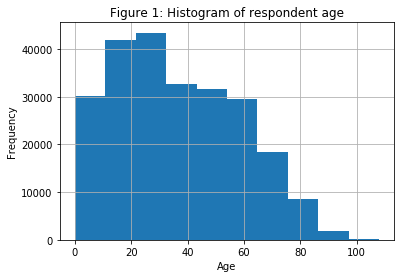

In [10]:
#Histogram of ages of respondents
hist_of_age = train['age'].hist()
plt.title("Figure 1: Histogram of respondent age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show();

Figure 1 caption: Histogram showing distribution of respondent age in the original dataset

Our EDA shows that respondents below age 17 (the voting age) are in our dataset. Given that the response variable is concerning political beliefs, we choose to restrict our data to respondents who are 17 or older. We also see there is a very small number of people who are over 100 years old. We remove these outliers so that our proportions by age aren't influenced by these small numbers.

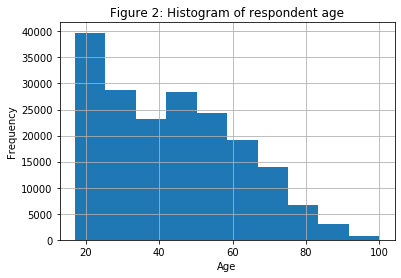

In [11]:
#Cut respondents under the age of 17 (voting age) and over the age of 100 (too small in numbers)
train_ages = train.query("age>16 & age<101")
train_ages['age'].hist()
plt.title("Figure 2: Histogram of respondent age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show();

Figure 2 caption: Histogram showing distribution of respondent age in the dataset, for respondents over 16 and under 101 years' old.

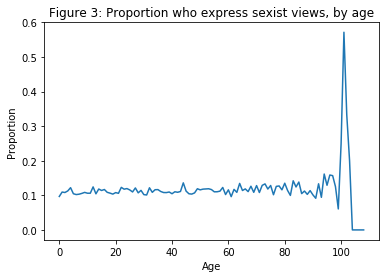

In [12]:
#proportion of people who hold sexist views by age
age_sexism = train.loc[:,['sexism', 'age']]
age_sexism

ind_ages = age_sexism.query("sexism==1|sexism==0")
ind_ages_grouped = ind_ages.groupby('age').sum()

ind_ages_grouped['total'] = ind_ages.groupby('age').count()['sexism']
ind_ages_grouped['proportion'] = ind_ages_grouped['sexism']/ind_ages_grouped['total']
plt.plot(ind_ages_grouped.index, ind_ages_grouped['proportion'])
plt.title("Figure 3: Proportion who express sexist views, by age")
plt.xlabel("Age")
plt.ylabel("Proportion")
plt.show();

Figure 3 caption: Proportion of respondents who express sexist view, by age

In the plot above there appears to be a small amount of variability in the proportion of people who hold sexist views in each year of age, but greater variability in older age groups (older than 90), likely because the number of people of that age is substantially smaller. We chose to group age into buckets to smooth the trend.

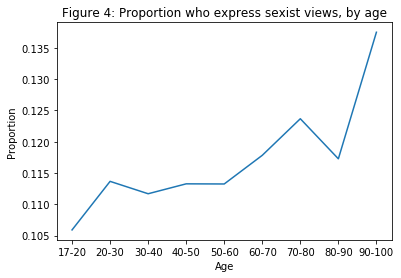

In [13]:
#Group ages into bins to show cleaner pattern

def AgeBuckets(data):
    '''
    bins ages into age ranges of ten
    use to create new series of age ranges in dataset
    '''
    labels = ['17-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
    edges = [17,21,31,41,51,61,71,81,91,101]
    age_categories = pd.cut(data['age'], edges, labels=labels)
    data['age_bucket'] = age_categories
    return data

eda_age = AgeBuckets(train)
eda_age = eda_age.groupby(('age_bucket', 'sexism')).size().unstack()
eda_age['proportion_sexist'] = eda_age[1]/(eda_age[0] + eda_age[1])
index = ['17-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
plt.plot(index, eda_age['proportion_sexist'])
plt.title("Figure 4: Proportion who express sexist views, by age")
plt.xlabel("Age")
plt.ylabel("Proportion")
plt.show();

Figure 4: Proportion of survey respondents who express sexist views, by age (bucketed into decade bins)

Binning the ages and restricting our ages to reasonable voting age (17 - 100) enables us to see a clearer trend in the proportion expressing sexist views: older populations are more likely to be of the opinion that men are better political leaders than women, which one might expect since many of the gender equality policy changes that have taken place in Colombia are relatively new and are driven by younger generations. 

We include binned age, rather than numeric age, in our model, and restrict our data to ages 17 - 100.

**Support for sexist views by gender**

In [14]:
# support for sexist views by sex:
sex_sexism = train.groupby('sex')['sexism'].value_counts()
print(f"In the dataset overall, {str(round(sex_sexism[0][1]/(sex_sexism[0][1]+sex_sexism[0][0])*100))} % female respondents say 'yes', men are better political leaders than women")
print(f"In the dataset overall, {str(round(sex_sexism[1][1]/(sex_sexism[1][1]+sex_sexism[1][0])*100))} % male respondents say 'yes', men are better political leaders than women")


In the dataset overall, 11.0 % female respondents say 'yes', men are better political leaders than women
In the dataset overall, 12.0 % male respondents say 'yes', men are better political leaders than women


**Year and sex**

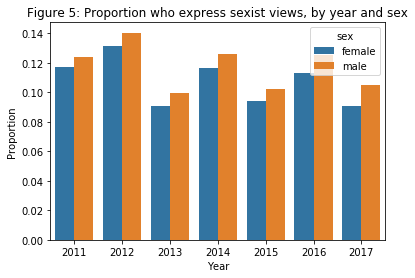

In [15]:
#Proportion of men and women who hold sexist views over time
sexist_by_gender = train.loc[:,['sexism', 'sex', 'year']]
sexist_by_gender = sexist_by_gender.query("sexism==1|sexism==0")
sexist_by_gender['sex'].replace(0, 'female', inplace = True)
sexist_by_gender['sex'].replace(1, 'male', inplace = True)

group_by_gender = sexist_by_gender.groupby(['year', 'sex']).sum()
group_by_gender['total count'] = sexist_by_gender.groupby(['year', 'sex']).count()[['sexism']]
group_by_gender['proportion'] = group_by_gender['sexism'] / group_by_gender['total count']
group_by_gender = group_by_gender.reset_index()
sns.barplot(x='year', y='proportion', hue='sex', data=group_by_gender)
plt.title("Figure 5: Proportion who express sexist views, by year and sex")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.show();

Figure 5 caption: Proportion of male and female survey respondents who express sexist views, by year of response.

This graph shows us that consistently, every year, there is a slightly higher proportion of men than women expressing sexist views.

**Proportion of sexist views for each feature**

In [16]:
#This helps inform us where to do eda visualizations and features that might not be worth including, 
#based on if there appears to be a difference in proportion expressing sexist view across each category

#proportion of people who hold sexist views across all features
for x in explanatory_variables:
    comparison = train.loc[:, ['sexism', x]]
    comparison = comparison.query("sexism==1|sexism==0")
    mean = comparison.groupby(x).mean().reset_index()
    print(mean)


   sex    sexism
0    0  0.108532
1    1  0.117979
   year    sexism
0  2011  0.119969
1  2012  0.135683
2  2013  0.094780
3  2014  0.120844
4  2015  0.097562
5  2016  0.118424
6  2017  0.097315
   marital_status    sexism
0             -88  0.000000
1               1  0.111973
2               2  0.115882
3               3  0.112090
4               4  0.105285
5               5  0.124029
6               6  0.111741
                district    sexism
0              ALTAVISTA  0.127298
1               ARANJUEZ  0.112106
2                  BELEN  0.092247
3           BUENOS AIRES  0.105173
4               CASTILLA  0.112217
5        DOCE DE OCTUBRE  0.104547
6             EL POBLADO  0.099048
7               GUAYABAL  0.106250
8             LA AMERICA  0.097683
9          LA CANDELARIA  0.090269
10      LAURELES-ESTADIO  0.100653
11              MANRIQUE  0.126342
12              PALMITAS  0.140449
13               POPULAR  0.150585
14               ROBLEDO  0.116267
15  SAN ANTONIO DE PR

**Socio-economic status**

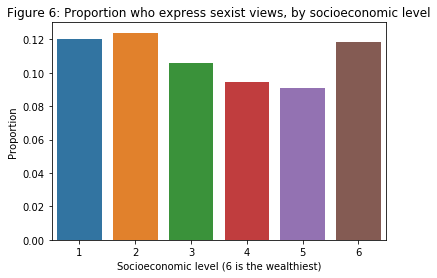

In [17]:
#sexist views held by people of different socioeconomic statuses
ses_sexism = train.loc[:, ['sexism','ses_level']]
ses_sexism = ses_sexism.query("sexism==1|sexism==0")
grouped_ses_sexism = ses_sexism.groupby('ses_level').sum()
grouped_ses_sexism['total'] = ses_sexism.groupby('ses_level').count()['sexism']
grouped_ses_sexism['proportion'] = grouped_ses_sexism['sexism'] / grouped_ses_sexism['total']
grouped_ses_sexism = grouped_ses_sexism.reset_index()

sns.barplot(x='ses_level', y='proportion', data=grouped_ses_sexism)
plt.title("Figure 6: Proportion who express sexist views, by socioeconomic level")
plt.xlabel("Socioeconomic level (6 is the wealthiest)")
plt.ylabel("Proportion")
plt.show();

Figure 6 caption: Proportion of survey respondents who express sexist views, by socioeconomic level ("estrato") whereby estrato 1 is the poorest and estrato 6 is the wealthiest.


Interestingly, it appears that there are differences in proportion of people in each socioeconomic level who express sexist views, but it is not linear. There is a slight decline as wealth increases, until we get to the wealthiest class.

**Educational Attainment**

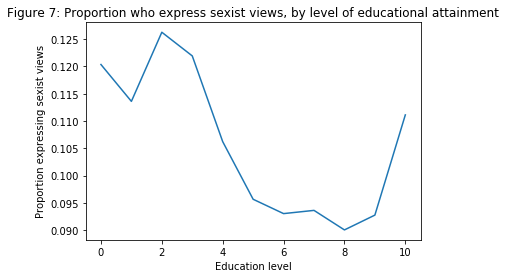

In [18]:
#sexist views held by people by educational attainment
ed_sexism = train.loc[:, ['sexism','education_level']]
ed_sexism = ed_sexism.query("sexism==1|sexism==0")
ed_sexism = ed_sexism.query("education_level>=0")
grouped_ed_sexism = ed_sexism.groupby('education_level').sum()
grouped_ed_sexism['total'] = ed_sexism.groupby('education_level').count()['sexism']
grouped_ed_sexism['proportion'] = grouped_ed_sexism['sexism'] / grouped_ed_sexism['total']
grouped_ed_sexism = grouped_ed_sexism.reset_index()

plt.plot(grouped_ed_sexism['education_level'], grouped_ed_sexism['proportion'])
plt.title("Figure 7: Proportion who express sexist views, by level of educational attainment")
plt.xlabel("Education level")
plt.ylabel("Proportion expressing sexist views")
plt.show();

Figure 7 caption: Proportion of respondents who express sexist views, by education level, whereby 0 indicates no education and 10 indicates doctoral level education

We see that as people get more education, the proportion expressing sexist views goes down... until very high levels of education where it spikes back up.

While the education_level variable is categorical, it is ordinal, meaning that a level of 10 is higher than a level of 1. However, we feel it would be 'truer' to the data to turn this into genuine categories and treat the data as categorical data in our model since some levels can be grouped together for the purpose of our analysis. The following function bins education levels into a more consolidated set of education levels.

In [19]:
def EducationCompleted(data):
    """
    Create more consolidated set of education levels in dataframe
    """
    labels = ['nothing','preschool','primary','secondary','other_post_secondary','university','masters','doctorate']
    edges = [-1,0,1,2,3,7,9,10,11]
    education_completed = pd.cut(data['education_level'], edges, labels=labels)
    data['education_completed'] = education_completed
    return data

#0	No estudió
#1	Preescolar
#2	Primaria
#3	Secundaria
#4	Media académica o normalista
#5	Media Técnica
#6	Tecnológico
#7	Universidad
#8	Especializacion
#9	Maestria
#10	Doctorado
#11	Educación no formal (NOT IN DATASET)
#-99	No responde
#-98	No sabe

In [20]:
def FamilyPolitician(data):
    """
    Encodes family politician variable as yes/no rather than amount
    """
    data['family_politician_male'] = ['yes' if x > 0 else 'no' for x in data['family_politician_male']]
    data['family_politician_female'] = ['yes' if x > 0 else 'no' for x in data['family_politician_female']]
    return data

## 3.2 Data Cleaning and Feature Engineering

Based on the EDA above, we chose to retain all original variables in our design matrix, and convert them to categorical variables to one-hot-encode. We will bin age so they are grouped by decades, and drop data from non-voting age survey respondents. We will also group some education levels together to simplify levels of education completed by survey participants. The following cells create and execute functions to one-hot encode our data, apply all of the transformations described above, and create additional splits of our data according to whether the features are considered features relating to demographic data or political engagement.

##### One Hot Encoding

In [21]:
def OHE(data):
    """
    One-hot-encodes variables. New cols are of the form variableVALUE
    """
    
    # recode variables that have multiple values to be dropped
    data['marital_status'].replace([-88,1], 'drop', inplace = True)
    data['race'].replace([-99,-98], 'drop', inplace = True)
    data['voted_last_election'].replace([-99,-98,-88], 'drop', inplace = True)
    data['field_of_study'].replace([-99,-98,-88], 'drop', inplace = True)
    data['primary_activity'].replace([-99,-88], 'drop', inplace = True)
    data['household_economic_conditions'].replace([-99,-98], 'drop', inplace = True)
    data['municipal_health'].replace([-99,-98], 'drop', inplace = True)
    data['municipal_education'].replace([-99,-98], 'drop', inplace = True)
    data['trust_mayor'].replace([-99,-98], 'drop', inplace = True)
    data['trust_courts'].replace([-99,-98], 'drop', inplace = True)
    data['trust_council'].replace([-99,-98], 'drop', inplace = True)
    data['family_planning_info'].replace([-99,-98, -88], 'drop', inplace = True)
    data['family_planning_use'].replace([-99,-98, -88], 'drop', inplace = True)
    data['health'].replace([-99,-98], 'drop', inplace = True)
    
    
    #create dictionary in which each key is the variable to be one-hot-encoded, 
    # and each value is the variable to be dropped from the encoding.
    ohe_vars = {
        'sex': '0',
        'year': '2011', 
        'marital_status': 'drop',
        'district': 'PALMITAS',
        'ses_level': '1', #arguably this could be kept without ohe because it's ordinal...
        'age_bucket': '90-100',# DONE!
        'race': 'drop',
        'voted_last_election': 'drop',
        'literate': '1',
        'education_completed': 'nothing',
        'field_of_study': 'drop',
        'primary_activity': 'drop',
        'household_economic_conditions': 'drop',
        'municipal_health': 'drop',
        'municipal_education': 'drop', #-98 is 'Do Not Know'
        'municipal_satisfaction': '-99',
        'trust_mayor': 'drop',
        'trust_courts': 'drop',
        'trust_council': 'drop',
        'interest_in_politics': '1',
        'family_politician_male': 'no', 
        'family_politician_female': 'no', 
        'trust_government': '1',
        'freedom_of_expression': '1',
        'neighborhood_safety': '1',
        'food_insecurity': '0.0', 
        'family_planning_info': 'drop', 
        'family_planning_use': 'drop', 
        'quality_of_life': '1',
        'health': 'drop'
        
    }
    data_ohe = data
    for i in np.arange(len(ohe_vars)):
        var = list(ohe_vars)[i]
        data_ohe = pd.get_dummies(data_ohe, prefix=var,prefix_sep='',
                          columns=[var],drop_first=False)
        data_ohe.drop(columns=var + ohe_vars[var],inplace=True)

    return data_ohe

##### Function that takes input data (train or test) and performs all data cleaning on it in one fell swoop

In [22]:
def CleanData(data):
    """
    Performs all cleaning on data. Input: raw data (train or test), output: clean data.
    """
    # cut ages below 16 or over 100
    data = data.query("age>16 & age<101")
    
    #Group ages into bins to show cleaner pattern and add this to the dataframe
    data = AgeBuckets(data)
    
    #Create more consolidated set of education levels in dataframe
    data = EducationCompleted(data)

    #delete the variables that we used the encoded version of
    data.drop(columns = ['education_level', 'age'], inplace = True) 
    
    #Re-assigns values for politicians in the family 
    data = FamilyPolitician(data)
    
    # Performs one hot encoding on all the data
    data = OHE(data)
    
    # Add bias column (column of 1s)
    data['bias'] = 1
    
    return data


train = CleanData(train)
test = CleanData(test)

In [23]:
#Create additional splits of data based on whether features are for demographic or political engagement features, 
#in order to build alternative models

demog = (['n_male_children', 'n_female_children', 'sexism', 'sex1',
       'year2012', 'year2013', 'year2014', 'year2015', 'year2016',
       'year2017', 'marital_status2', 'marital_status3',
       'marital_status4', 'marital_status5', 'marital_status6',
       'districtALTAVISTA', 'districtARANJUEZ', 'districtBELEN',
       'districtBUENOS AIRES', 'districtCASTILLA',
       'districtDOCE DE OCTUBRE', 'districtEL POBLADO',
       'districtGUAYABAL', 'districtLA AMERICA', 'districtLA CANDELARIA',
       'districtLAURELES-ESTADIO', 'districtMANRIQUE', 'districtPOPULAR',
       'districtROBLEDO', 'districtSAN ANTONIO DE PRADO',
       'districtSAN CRISTOBAL', 'districtSAN JAVIER',
       'districtSANTA CRUZ', 'districtSANTA ELENA',
       'districtVILLA HERMOSA', 'ses_level2', 'ses_level3', 'ses_level4',
       'ses_level5', 'ses_level6', 'age_bucket17-20', 'age_bucket20-30',
       'age_bucket30-40', 'age_bucket40-50', 'age_bucket50-60',
       'age_bucket60-70', 'age_bucket70-80', 'age_bucket80-90', 'race1',
       'race2', 'race3', 'race4', 'race5', 'race6', 'literate0',
       'education_completedpreschool', 'education_completedprimary',
       'education_completedsecondary',
       'education_completedother_post_secondary',
       'education_completeduniversity', 'education_completedmasters',
       'education_completeddoctorate', 'field_of_study1',
       'field_of_study2', 'field_of_study3', 'field_of_study4',
       'field_of_study5', 'field_of_study6', 'field_of_study7',
       'field_of_study8', 'field_of_study9', 'field_of_study10',
       'field_of_study11', 'field_of_study12', 'field_of_study13',
       'field_of_study14', 'field_of_study15', 'field_of_study16',
       'primary_activity1', 'primary_activity2', 'primary_activity3',
       'primary_activity4', 'primary_activity5', 'primary_activity6',
       'primary_activity7', 'primary_activity8',
       'household_economic_conditions1', 'household_economic_conditions2',
       'household_economic_conditions3', 'neighborhood_safety-98',
       'neighborhood_safety2', 'neighborhood_safety3',
       'food_insecurity1.0', 'family_planning_info1',
       'family_planning_info2', 'family_planning_use1',
       'family_planning_use2', 'quality_of_life2', 'quality_of_life3',
       'quality_of_life4', 'quality_of_life5', 'health1.0', 'health2.0',
       'health3.0', 'health4.0', 'bias'])

polit = ([ 'sexism', 
       'year2012', 'year2013', 'year2014', 'year2015', 'year2016',
       'year2017', 
       'voted_last_election1', 'voted_last_election2',  'municipal_health1',
       'municipal_health2', 'municipal_health3', 'municipal_education1',
       'municipal_education2', 'municipal_education3',
       'municipal_satisfaction1', 'municipal_satisfaction2',
       'municipal_satisfaction3', 'municipal_satisfaction4',
       'municipal_satisfaction5', 'trust_mayor1', 'trust_mayor2',
       'trust_courts1', 'trust_courts2', 'trust_council1',
       'trust_council2', 'interest_in_politics2', 'interest_in_politics3',
       'interest_in_politics4', 'interest_in_politics5',
       'family_politician_maleyes', 'family_politician_femaleyes',
       'trust_government2', 'trust_government3', 'trust_government4',
       'trust_government5', 'freedom_of_expression2',
       'freedom_of_expression3', 'freedom_of_expression4',
       'freedom_of_expression5', 'bias'])
                             
train_demog = train.loc[:,demog]
test_demog = test.loc[:,demog]

train_polit = train.loc[:,polit]
test_polit = test.loc[:,polit]

In [24]:
# Inspect new train dataset and engineered features
print(f"train: {train.shape}, test: {test.shape}")

for var in train.columns.values:
    print(var)
    print(train[var].value_counts())
    print('\n')

train: (188043, 139), test: (46986, 139)
n_male_children
0     130744
1      29459
2      15498
3       6323
4       2854
5       1425
6        818
7        444
8        256
9        109
10        50
11        30
12        14
13         9
15         4
14         3
16         2
20         1
Name: n_male_children, dtype: int64


n_female_children
0     132526
1      29359
2      14410
3       5798
4       2614
5       1468
6        830
7        460
8        274
9        145
10        73
12        29
11        26
13         8
14         5
15         5
19         4
20         4
16         3
18         2
Name: n_female_children, dtype: int64


sexism
0    166688
1     21355
Name: sexism, dtype: int64


sex1
0    105723
1     82320
Name: sex1, dtype: int64


year2012
0    158319
1     29724
Name: year2012, dtype: int64


year2013
0    158333
1     29710
Name: year2013, dtype: int64


year2014
0    158150
1     29893
Name: year2014, dtype: int64


year2015
0    159286
1     28757
Name: year20

Name: bias, dtype: int64




## 3.3 Model

We built a model that predicts sexism based on 32 features related to demographic data and political engagement. Our response variable, sexism, is the response to the question: “Do you believe that men are better political leaders than women?”. It is a binary yes/no question, and therefore we use a logistic regression for our model. 

The design matrix for our model contains data that is either one-hot encoded (categorical data) or standardized to have a mean of 0 and standard deviation of 1 (continuous data). This enables fair comparison of the influence of each feature on the model, without confounding due to difference variance or magnitude.

Given the large number of features (particular when one-hot encoded), we use regularization to penalize additional coefficients. By using L1 “lasso” regularization, we set low coefficients to zero, therefore encouraging sparsity in our model. 

We use five-fold cross validation to choose the appropriate regularization coefficient in our model. The scoring function that we use to select the appropriate regularization coefficient is not simply accuracy. Accuracy (# true positives + # true negatives / # predictions) is not the best metric to score in this case, given the dataset is unbalanced (i.e. only around 11% of people say ‘yes’ on our response variable), and therefore optimizing our model based on accuracy alone will lead to a model with very few positives, and therefore high precision and low recall. Instead, we need a scoring function that considers both precision and recall. We trial three different scoring functions, and select the one (f1) that imposes the strongest regularization while achieving high accuracy, precision, and recall. The three scoring functions we use are:

1. Balanced Accuracy: Balanced accuracy is defined as the average of recall obtained on each class, and ranges from 0 (worst) to 1 (best). It is used to deal with imbalanced datasets.
2. Negative Log Loss: Also known as cross entropy loss, this is the log-likelihood of the true labels, given the predictions. 
3. F1: The F1 score is the weighted average of precision and recall, and ranges from 0 (worst) to 1 (best). The formula is: 
$F1 = \frac{2 * (precision * recall)}{(precision + recall)}$

We chose the F1 scoring system, which yields the optimal regularization coefficient of 100 (in sklearn.LogisticRegressionCV, this is entered as the inverse, i.e. 0.01). When we impose this regularization coefficient using L1 regularization, we set 67 of the 138 total coefficients to zero. 

We implement the regression using sklearn.LogisticRegressionCV. We choose the ‘saga’ solver, because it works well on large datasets and is compatible with L1 regularization. 


In [25]:
## Build Logistic Regression - create design matrix and test array

from sklearn.preprocessing import StandardScaler

y_train = train['sexism']
y_test = test['sexism']

y_train_D = train_demog['sexism']
y_test_D = test_demog['sexism']

y_train_P = train_polit['sexism']
y_test_P = test_polit['sexism']

#create design matrix without the sexism column, and with numeric standardized (mean = 0, sd = 1)
def DesignMatrix(data):
    """Create a design matrix from dataframe."""
    # remove sexism column
    data = data.drop(columns = ['sexism'])
    
    #scale quantitative data (i.e. not the one-hot encoded data) so mean = 0, sd = 1
    scaler = StandardScaler()
    scaler.fit(data[['n_male_children']])
    data['n_male_children'] = scaler.transform(data[['n_male_children']])
    scaler.fit(data[['n_female_children']])
    data['n_female_children'] = scaler.transform(data[['n_female_children']]) 
    return data


#create design matrix without the sexism column for political data only
def DesignMatrixPolit(data):
    """Create a design matrix from dataframe."""
    # remove sexism column
    data = data.drop(columns = ['sexism']) 
    return data

X_train = DesignMatrix(train)
X_test = DesignMatrix(test)

X_train_D = DesignMatrix(train_demog)
X_test_D = DesignMatrix(test_demog)

X_train_P = DesignMatrixPolit(train_polit)
X_test_P = DesignMatrixPolit(test_polit)

In [26]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape} y_test: {y_test.shape}")

X_train: (188043, 138), X_test: (46986, 138), y_train: (188043,) y_test: (46986,)


In [27]:
#Summarize model accuracy and performance
#Add summary to dataframe with all model results

def ModelQuality(model):
    
    performance_summary = pd.DataFrame(columns = [
    "Model",
    "Accuracy",
    "Lambda",
    "Precision",
    "Recall",
    "Log loss"
    ])
    
    
    train_score = model.score(X_train, y_train) #note: this uses the scoring function from above
    test_score= model.score(X_test, y_test) #note: this uses the scoring function from above
    
    y_pred = model.predict(X_test)     
    true_pos = sum((y_test==y_pred) & (y_test==1))
    false_pos = sum((y_test!=y_pred) & (y_test==0))
    false_neg = sum((y_test!=y_pred) & (y_test==1))
    true_neg = sum((y_test==y_pred) & (y_test==0))

    accuracy = (true_pos + true_neg)/ (true_pos + true_neg + false_pos + false_neg)
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)
    logloss = log_loss(y_train, model.predict(X_train))

    performance_summary = performance_summary.append({
        "Model": model,
        "Accuracy": accuracy,
        "Lambda": float(model.C_),
        "Precision": precision,
        "Recall": recall,
        "Log loss": logloss
    }, ignore_index=True)
    
    return performance_summary

##### The following executes five-fold cross validation and uses regularization to select the optimal lambda value for each of the three models. We then fit each model and save key information about the model in a dataframe called performance_summary to visually compare the specificiations and results.

In [28]:
# Train three different models using cross-validation and regularize with seven different options for lambda

##### model 1: scoring = 'balanced_accuracy'
# model 2: scoring = 'neg_log_loss'
# model 3: scoring = 'f1'

model1 = sklearn.linear_model.LogisticRegressionCV(Cs=[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 10], fit_intercept=True, cv=5, penalty='l1', solver='saga', random_state=42, class_weight = 'balanced', max_iter = 1000, scoring = "balanced_accuracy")
model1.fit(X_train,y_train)

LogisticRegressionCV(Cs=[1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 10],
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l1', random_state=42, refit=True,
                     scoring='balanced_accuracy', solver='saga', tol=0.0001,
                     verbose=0)

In [29]:
performance_summary = ModelQuality(model1)

In [30]:
# Train three different models using cross-vaildation and regularize with seven different options for lambda

# model 1: scoring = 'balanced_accuracy'
##### model 2: scoring = 'neg_log_loss'
# model 3: scoring = 'f1'

model2 = sklearn.linear_model.LogisticRegressionCV(Cs=[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 10], fit_intercept=True, cv=5, penalty='l1', solver='saga', random_state=42, class_weight = 'balanced', max_iter = 1000, scoring = "neg_log_loss")
model2.fit(X_train,y_train)

LogisticRegressionCV(Cs=[1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 10],
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l1', random_state=42, refit=True,
                     scoring='neg_log_loss', solver='saga', tol=0.0001,
                     verbose=0)

In [31]:
performance_summary = performance_summary.append(ModelQuality(model2))

In [32]:
# Train three different models using cross-vaildation and regularize with seven different options for lambda

# model 1: scoring = 'balanced_accuracy'
# model 2: scoring = 'neg_log_loss'
##### model 3: scoring = 'f1'

model3 = sklearn.linear_model.LogisticRegressionCV(Cs=[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 10], fit_intercept=True, cv=5, penalty='l1', solver='saga', random_state=42, class_weight = 'balanced', max_iter = 1000, scoring = "f1")
model3.fit(X_train,y_train)

LogisticRegressionCV(Cs=[1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 10],
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l1', random_state=42, refit=True, scoring='f1',
                     solver='saga', tol=0.0001, verbose=0)

In [33]:
performance_summary = performance_summary.append(ModelQuality(model3))

##### Our model performance summary aggregrates the results of all three models to compare accuracy, precision, recall, and cross-entropy loss, as well as examine what level of regularization was used.

All three models perfomed roughly the same for accuracy, precision, recall, and cross-entropy loss. We elected to use the F1 model (model 3) since it uses the strongest regularization, and we care about producing the simplest, sparsest model and minimizing the risk of overfitting.

In [36]:
print("Table 1: Model quality for models using different scoring functions")

Table 1: Model quality for models using different scoring functions


In [34]:
performance_summary['Model'] = ['balanced_accuracy', 'neg_log_loss', 'f1']
performance_summary

,Model,Accuracy,Lambda,Precision,Recall,Log loss
0,balanced_accuracy,0.619482,1.00,0.163618,0.577061,12.980383
0,neg_log_loss,0.619206,10.00,0.163612,0.577627,12.986445
0,f1,0.623484,0.01,0.164555,0.573288,12.873849


**Table caption:** This table describes model performance for our models created to choose the optimum regularization hyperparameters. We tested three different scoring functions (balanced accuracy, negative log loss, and f1 score) and selected the f1 scoring system because it most harshly penalized additional coefficients (i.e. had the smallest 'lambda' score) without compromising on model accuracy. The outputs reported from the table are: 
* Accuracy: What proportion of points did the model classify correctly?
* Precision: Of all observations that were predicted to be 1, what proportion were actually 1?
* Recall: Of all observations that were actually 1, what proportion did we predict to be 1?
* Log Loss, also known as cross entropy loss: log-likelihood of the true labels, given the predictions. 
* Lambda: What is the inverse of the regularization coefficient used? Smaller lambda indicates a stronger penalty on additional features.

In [35]:
#save performance summary dataframe of all three models to a csv so we don't have to run them again
#performance_summary.to_csv('model_performance_summary', index=False)

In [59]:
#load in performance_summary df
#performance_summary = pd.read_csv('model_performance_summary')
#performance_summary

##### Test model performance across different subsets of features

After selecting our best model which uses F1 scoring, we wanted to run that model using three different sets of features from our train data: demographic only, political engagement only, and all features (note that we have already run this last model above). The purpose is to examine how and if the model is performing (i.e. changes in coefficient values) if we were to predict sexist views only through someone's demographic information, only through their level of political engagement and interest, or by considering all features.

In [38]:
# Create a performance summarythat can be used with all three of the following models with different features

#Summarize model accuracy and performance
#Add summary to dataframe with all model results

def ModelQuality_features(model, X_train, y_train, X_test, y_test):
    
    performance_summary = pd.DataFrame(columns = [
    "Model",
    "Accuracy",
    "Precision",
    "Recall",
    "Log loss"
    ])
    
    train_score = model.score(X_train, y_train) #note: this uses the scoring function from above
    test_score= model.score(X_test, y_test) #note: this uses the scoring function from above
    
    y_pred = model.predict(X_test)     
    true_pos = sum((y_test==y_pred) & (y_test==1))
    false_pos = sum((y_test!=y_pred) & (y_test==0))
    false_neg = sum((y_test!=y_pred) & (y_test==1))
    true_neg = sum((y_test==y_pred) & (y_test==0))

    accuracy = (true_pos + true_neg)/ (true_pos + true_neg + false_pos + false_neg)
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)
    logloss = log_loss(y_train, model.predict(X_train))
    
    model_coef = model.coef_
    coef = model_coef[0,:]
    coef = sum(coef!=0)
    
    performance_summary = performance_summary.append({
        "Model": model,
        "Number of non-zero features": coef,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Log loss": logloss
    }, ignore_index=True)
    
    return performance_summary

In [39]:
# RE-RUN THAT MODEL WITH TWO SUBSETS OF THE DATA TO COMPARE WITH MODEL THAT HAS ALL FEATURES

##### MODEL3_D = DEMOGRAPHIC FEATURES ONLY
# MODEL3_P = POLITICAL ENGAGEMENT FEATURES ONLY
# MODEL3_DP = DEMOGRAPHIC FEATURES ONLY AND POLITICAL ENGAGEMENT FEATURES

model3_D = sklearn.linear_model.LogisticRegressionCV(Cs=[1e-2], fit_intercept=True, cv=5, penalty='l1', solver='saga', random_state=42, class_weight = 'balanced', max_iter = 1000, scoring = "f1")
model3_D.fit(X_train_D,y_train_D)

LogisticRegressionCV(Cs=[0.01], class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l1', random_state=42, refit=True, scoring='f1',
                     solver='saga', tol=0.0001, verbose=0)

In [40]:
performance_summary_features = ModelQuality_features(model3_D, X_train_D, y_train_D, X_test_D,y_test_D)

In [41]:
# MODEL3_D = DEMOGRAPHIC FEATURES ONLY
##### MODEL3_P = POLITICAL ENGAGEMENT FEATURES ONLY
# MODEL3_DP = DEMOGRAPHIC FEATURES ONLY AND POLITICAL ENGAGEMENT FEATURES

model3_P = sklearn.linear_model.LogisticRegressionCV(Cs=[1e-2], fit_intercept=True, cv=5, penalty='l1', solver='saga', random_state=42, class_weight = 'balanced', max_iter = 1000, scoring = "f1")
model3_P.fit(X_train_P,y_train_P)

LogisticRegressionCV(Cs=[0.01], class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l1', random_state=42, refit=True, scoring='f1',
                     solver='saga', tol=0.0001, verbose=0)

In [42]:
performance_summary_features = performance_summary_features.append(ModelQuality_features(model3_P, X_train_P, y_train_P, X_test_P, y_test_P))

In [43]:
# MODEL3_D = DEMOGRAPHIC FEATURES ONLY
# MODEL3_P = POLITICAL ENGAGEMENT FEATURES ONLY
#####  MODEL3_DP = DEMOGRAPHIC FEATURES ONLY AND POLITICAL ENGAGEMENT FEATURES

model3_DP = sklearn.linear_model.LogisticRegressionCV(Cs=[1e-2], fit_intercept=True, cv=5, penalty='l1', solver='saga', random_state=42, class_weight = 'balanced', max_iter = 1000, scoring = "f1")
model3_DP.fit(X_train,y_train)

LogisticRegressionCV(Cs=[0.01], class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l1', random_state=42, refit=True, scoring='f1',
                     solver='saga', tol=0.0001, verbose=0)

In [44]:
performance_summary_features = performance_summary_features.append(ModelQuality_features(model3_DP, X_train, y_train, X_test, y_test))

In [45]:
print("Table 2: Model Performance for models using different input features")

Table 2: Model Performance for models using different input features


In [46]:
performance_summary_features['Model'] = ['Demographic features', 'Political engagement features', 'All features']
performance_summary_features

,Model,Accuracy,Precision,Recall,Log loss,Number of non-zero features
0,Demographic features,0.564785,0.138300,0.546312,14.926277,55.0
0,Political engagement features,0.619780,0.160799,0.561781,12.990117,26.0
0,All features,0.623484,0.164555,0.573288,12.873849,71.0


**Table caption:** This table describes model performance for our three different models (full feature, political engagement features only, and demographic features) using logistic regression with L1 regularization with a regularization coefficient of 100. The outputs reported are:
* Accuracy: What proportion of points did the model classify correctly?
* Precision: Of all observations that were predicted to be 1, what proportion were actually 1?
* Recall: Of all observations that were actually 1, what proportion did we predict to be 1?
* Log Loss, also known as cross entropy loss: log-likelihood of the true labels, given the predictions. 
* Number of non-zero features: The number of features in the model that were not set to zero by the L1 "lasso" regularization. For a given accuracy, the better model will be the one with less features (i.e. a simpler, more parsimonious model)

In [47]:
#save performance summary dataframe of all three models to a csv so we don't have to run them again
#performance_summary_features.to_csv('model_performance_summary_features', index=False)

In [48]:
#comment out the above cell and run this to load df back in...
#performance_summary_features = pd.read_csv('model_performance_summary_features')
#performance_summary_features

The above dataframe shows how our model performed across all three feature sets. We can see that using demographic features to predict sexist views is least effective with lower model performance across the board on accuracy, precision, recall, and cross-entropy loss. 

Using political engagement features and both political and demographic features (all features) were roughly similar, while the model that used all features performed slightly better.

# 4. Results

#### Confusion Matrix

[[26256 15429]
 [ 2262  3039]]
[[0.62986686 0.37013314]
 [0.42671194 0.57328806]]


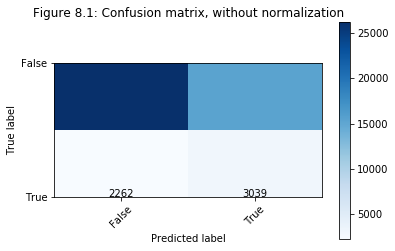

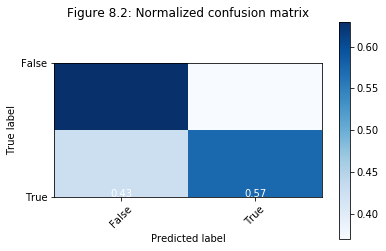

In [49]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, model3_DP.predict(X_test))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Figure 8.2: Normalized confusion matrix"
    else:
        title = 'Figure 8.1: Confusion matrix, without normalization'

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title, y=1.3)
    
class_names = ['False', 'True']
# Plot non-normalized confusion matrix
plt.figure();
plot_confusion_matrix(cnf_matrix, classes=class_names);

# Plot normalized confusion matrix
plt.figure();
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True);

Figure 8 caption: "Confusion matrix" showing rates of false positives, false negatives, true positives, and true negatives for the full feature model, with and without normalization.


The confusion matrix (for the model with all features) shows that 57% of the test set were correctly predicted as true (true positive) and 63% were correctly predicted as false (true negative). 

### ROC curve

In [50]:
# Computations for ROC curves

def compute_TPR_FPR(y_obs, y_hat):
    TP = sum((y_obs == y_hat) & (y_obs == 1))
    FN = sum((y_obs != y_hat) & (y_obs == 1))
    TPR = TP / (TP + FN)
    
    TN = sum((y_obs == y_hat) & (y_obs == 0))
    FP = sum((y_obs != y_hat) & (y_obs == 0))
    FPR = FP / (FP + TN)
       
    return TPR, FPR

def compute_model_TPR_FPR(model, X_test, y_obs, threshold):    
    y_hat = model.predict_proba(X_test)[:,1]  > threshold # returns True/False depending on if above threshold or not
    return compute_TPR_FPR(y_obs, y_hat)

In [51]:
#ROC Curve for model# with demographic data only:
thresholds = np.linspace(0, 1, 101)
TPRs_best_model_D = []
FPRs_best_model_D = []
for threshold in thresholds:
    TPR, FPR = compute_model_TPR_FPR(model3_D, X_test_D, y_test_D, threshold)
    TPRs_best_model_D.append(TPR)
    FPRs_best_model_D.append(FPR)
        

#ROC Curve for model# with political engagement data only: 
thresholds = np.linspace(0, 1, 101)
TPRs_best_model_P = []
FPRs_best_model_P = []
for threshold in thresholds:
    TPR, FPR = compute_model_TPR_FPR(model3_P, X_test_P, y_test_P, threshold)
    TPRs_best_model_P.append(TPR)
    FPRs_best_model_P.append(FPR)

    
#ROC Curve for model# with all features:
thresholds = np.linspace(0, 1, 101)
TPRs_best_model_DP = []
FPRs_best_model_DP = []
for threshold in thresholds:
    TPR, FPR = compute_model_TPR_FPR(model3_DP, X_test, y_test, threshold)
    TPRs_best_model_DP.append(TPR)
    FPRs_best_model_DP.append(FPR)

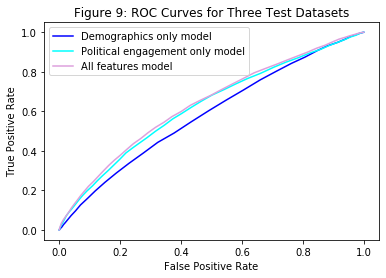

In [52]:
#Plot all three ROC curves together
plt.figure()
plt.plot(FPRs_best_model_D, TPRs_best_model_D, color = 'blue', label = 'Demographics only model')
plt.plot(FPRs_best_model_P, TPRs_best_model_P, color = 'aqua', label = 'Political engagement only model')
plt.plot(FPRs_best_model_DP, TPRs_best_model_DP, color = 'plum', label = 'All features model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 9: ROC Curves for Three Test Datasets')
plt.legend();

#Save figure as png
plt.savefig("ROC curve for all three datasets")

Figure 9 caption: Receiver operating characteristic (ROC) curve for the three models (demographic only, political engagement only, all features), which charts the tradeoff between true positive and false positive rates at different thresholds for classification cut-off.


The ROC curve is consistent with our assessment of the models above, which show demographic information as a worse predictor of expressing sexist views, although all feature sets and models tested do not provide a good prediction overall. (A well-fitted model would have an ROC curve that rises steeply and then plateaus near a true positive rate of 1, while our model takes an almost linear increase.)

In [53]:
#inspect the coefficients:
a = model3_DP.coef_
coefficient = a[0,:]
feature = X_test.columns.values
coefs = pd.DataFrame(data = {'feature': feature, 'coefficient': coefficient, 'coefficient_abs': np.abs(coefficient)})
coefs = coefs.sort_values('coefficient_abs', ascending = False)
coefs

,feature,coefficient,coefficient_abs
101,trust_mayor1,0.392821,0.392821
103,trust_courts1,0.297313,0.297313
109,interest_in_politics4,0.265666,0.265666
92,municipal_health3,-0.228779,0.228779
87,household_economic_conditions1,0.225578,0.225578
...,...,...,...
63,field_of_study1,0.000000,0.000000
62,education_completeddoctorate,0.000000,0.000000
61,education_completedmasters,0.000000,0.000000
58,education_completedsecondary,0.000000,0.000000


In [54]:
sum(coefs['coefficient']==0)

67

In [55]:
#save performance summary dataframe of all three models to a csv so we don't have to run them again
#coefs.to_csv('coefficients_model2', index=False)

#comment out the above cell and run this to load df back in...
#coefficients_model2 = pd.read_csv('coefficients_model2')
#coefficients_model2 

In [56]:
#coefficients_model3 = pd.read_csv('coefficients_model3')
#coefficients_model3

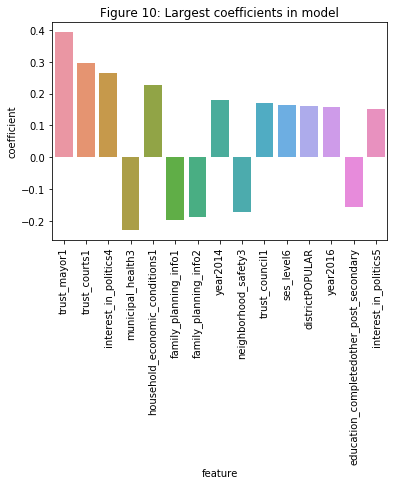

In [57]:
#generate graph of coefficients

#limit data so it only takes features with abs(coef) > 0.15
plot_data = coefs.query("coefficient_abs > 0.15")
sns.barplot(x = plot_data['feature'], y = plot_data['coefficient'])
plt.xticks(rotation='vertical')
# plt.ylim(-0.5,0.5)
plt.title("Figure 10: Largest coefficients in model")
plt.show();

#-98 = "don't know"...sucks that this is the largest predictor...
#-99 = "no response" ... sucks that this is the second largest predictor
#race 5 = Raizal -Sanandresano, race 6  = Rom - Gitano (probably small n... not sure)
#field of study 12 = environmental engineering

Figure 10 caption: Value of the largest 15 coefficients in the full feature model, sorted by magnitude.

For the model containing all features, we found that all features have relatively small coefficients, but those who reported having low trust in the mayor and courts (value of 1), and those  having a high interest in politics (value of 4) were shown to have the greatest predictive value of expressing sexist views based on coefficient size. 67 of the 138 coefficient were set to zero.

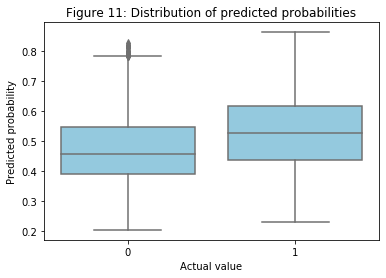

In [58]:
probs = pd.DataFrame(model3_DP.predict_proba(X_test))[1].values

ax = sns.boxplot(x = y_test.values, y = probs,color='skyblue')
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted probability')
plt.title("Figure 11: Distribution of predicted probabilities");

Figure 11 caption: Side-by-side boxplot showing the distribution of predicted values from the full feature model, where an actual value of 1 is the "sexist" response. 

If the model were effective at classifying sexist vs. not-sexist views, we would see the distribution of probabilities predicted to differ substantially for those with an actual value of 1 ("sexist") and those with an actual value of 0 ("not-sexist"). In other words, we would want to see minimal overlap in the boxplots. There is a small difference in the distribution of predicted probabilities, but not enough to provide meaningful predictions. 

# 5. Discussion


#### Interpretation of Results

We first built a model using all selected features utilizing cross-validation and L1 loss. This yields an accuracy of 62%, 16% precision, 57% recall, and 12.87 cross-entropy loss. The true positive rate was 57% and the false positive rate was 37%. Our best model was therefore not a good predictor of expressing sexist views. This is disappointing, but unsurprising, since sexism is a complex and nuanced trait. Especially today when expressing overtly sexist views is not as socially acceptable as it was 40 years ago, people like to think of themselves as good people who are not sexist, even though they may in fact internally hold, perpetuate, or share in private social situations, sexist views. Therefore, it is difficult to predict this trait in people and even more so complex when, potentially, a person's actions (such as consistently voting for a male candidate over a female candidate) may reflect something different than what they say about themselves.

We then investigate to see whether a simpler model, with fewer features, will perform to a comparable degree of accuracy. We divide the features into two categories: demographic, and political engagement, to determine whether models built on either of these categories will perform well. We chose this categorization of features because we want to test if demographic features alone are adequate at explaining someone’s views on whether male politicians are better than female politicians, or, given the political nature of the question, whether simply questions about their level of political engagement are sufficient in predicting their response to this question. We find that the political engagement model performs similarly to the full demographic model (accuracy: 62.0%), while the demographic model is substantially worse (accuracy: 56.5%). This is surprising to us, because we would have expected demographics to be better than the level of political engagement at predicting someone’s sexist beliefs, and our exploratory data analysis showed small but meaningful differences in sexist beliefs according to key demographic features such as age, level of education, and socioeconomic status. This result tells us that, in effect, we can drop all demographic features with no real decline in the model’s predictive power.

We plot a receiver operating characteristic (ROC) curve, to illustrate the diagnostic ability of our three models as the threshold for classification changes. This also shows similar, but poor, performance for the full model and political engagement model, and worse performance for the demographic model. In a well-fitting model, we would expect a curve that rises steeply and then plateaus near a true positive rate of 1, while our model takes an almost linear increase. Again, this demonstrates the poor precision and recall of our model.

We also calculate a confusion matrix for our full model, which shows the trade-off between the true-positive and true-negative rates. We see that 57% of the test set were correctly predicted as true (true positive) and 63% were correctly predicted as false (true negative). This is not a well-performing model; we would hope for the true positive and true negative rates to be much higher. Our model has much higher recall (57%) than precision (16%), which reflects that our model picks up more false positives than false negatives. In other words, it is diagnosing people as sexist who in fact are not (according to our simple definition of sexism: whether you believe male politicians are better than female politicians). 

Finally, we look at the coefficients of the full model, to see which features have the largest coefficients. A feature with a large coefficient (positive or negative) has a greater contribution towards predicting sexism. No causal inferences can be drawn from this analysis, but it can still be helpful in describing which groups of people in Medellin display more sexist behavior, and could help both understand sexist beliefs and target interventions to change sexist behavior. We find relatively low coefficients across the board (after L1 regularization), with the highest values from:
Trust in mayor: more likely to be sexist;
Trust in courts: more likely to be sexist;
Strong interest in politics: more likely to be sexist;
Satisfaction with municipal health: less likely to be sexist;
Poor household economic conditions: more likely to be sexist.

While no causal claims can be made, one can draw common sense explanations for all of these coefficients’ role in sexist beliefs. Those who trust the mayor or court system might be less likely to support female politicians because they're already content with the male-dominant status quo; those who are generally satisfied with how the government has maintained health standards in their municipality might be more open to the women in the current administration who have helped achieve these standards; those from economically disadvantaged households might be less open to change, and conservative views have traditionally looked down upon female participation in government. More interestingly, though, this analysis offers a point of entry for intervention design for organizations looking to achieve greater gender equality in Medellin. They may target advocacy campaigns to those who already trust the political system or those with poor household economic conditions. 

#### Limitations

One limitation of this analysis is how the data was collected and the sturcture of the household survey itself. Since the household survey is widely distributed across the city and data is collected through household visits, there is a large opportunity for bias based on how the survey respondent percieves the survey administrator. Specifically, if there are differences in the gender or age, possible threats to anonymity, or other external factors present that may influence how open and truthful the survey participant responded to the questions, which could influence the integrity of the analysis. 

Additionally, the survey questions were constructed to answer questions related to quality of life as opposed to individuals' views and perspectives related to gender equality and sexism, so the questions were not necessarily written or verbally delivered to the participant in a way that would be ideal for our analysis. Furthermore, since the authors of this analysis are not fluent spanish speakers, we heavily relied on Google Translate to interpret the meaning and purpose behind each question and the underlying documentation about how the survey was administered.

Lastly, our proxy for sexist political beliefs is based off a response to a single question ("do you believe that men are better political leaders than women?"). This is a substantial shortcoming, as beliefs around gender and sexism are complex and nuanced, and a proxy of sexism would ideally be built off richer data than a single question.


#### Future work

Future research could expand the variables included from the survey to build a richer set of features and a more nuanced response variable (e.g. PCA to construct a composite index based on responses to a variety of questions pertaining to sexist beliefs), to see if this improves the model's predictive accuracy. However, a more fruitful line of enquiry could be to pursue some of the different data sources available from the Colombian Government's open data portal to find data that has been collected specifically with the aim of measuring sexism/perceptions of gender equality, and use this to build a stronger model. For example, the national 'Como Vamos' survey could be a more suitable dataset. However, ultimately, the answer could simply be 'no': that sexism cannot be predicted by a set of features measurable on paper, and instead requires a more qualitative and holistic assessment of a person's beliefs.


# 6. Conclusion

In conclusion, data from a household quality of life survey in Colombia, Medellin, does poorly at predicting sexist beliefs as measured by response to the question: "do you believe that men are better political leaders than women?". A full model constructed from 32 survey questions related to demographic data and political engagemet has accuracy of 62%, precision of 16% and recall of 57%. A model built with political engagement features alone performs comparably to the full model, while a model built with demographic features alone performs worse, suggesting that political engagement data is a better proxy for predicting sexist beliefs than demographic information. Features with the most influence on the model are: having trust in the mayor and courts system, and strong interest in politics. While causal inferences cannot be made from this model, a recognition of the role of these features in predicting sexist beliefs could help target interventions seeking to change sexist political beliefs in Medellin.

# 7. Appendices

The following appendices are included in the folder for this project:
* Raw data (csv)
* Full data dictionary (in spanish)
* Translations of the variables used in our analysis